## Introduction

This notebook provides a simple example on how to use the kernelized Taylor diagram for visualizing similarities in data. In this example, we generate some random data and transform it with progressively more complex transformations.

This first block simply loads the required packages and creates the data.

In [11]:
# @title load package and generate data



from typing import List, Optional, Union, NamedTuple, Callable, Tuple

import collections
import numpy as np
import matplotlib.pyplot as plt


from sklearn.base import BaseEstimator
from matplotlib.projections import PolarAxes
from sklearn.preprocessing import KernelCenterer
from scipy.spatial.distance import pdist, squareform
from sklearn.utils import check_array, check_random_state
from mpl_toolkits.axisartist import floating_axes, grid_finder
from sklearn.metrics.pairwise import linear_kernel, pairwise_kernels


np.random.seed(1)
N = 500
x = np.random.uniform(0, np.pi, size=(N, 1))

## Functions and classes from pysim

The three following blocks contain classes and functions that we need to create the kernelized Taylor diagram. They are obtained from the PySim Github repo: https://github.com/jejjohnson/pysim, but are listed here to make the notebook self contained.

In [12]:
#@title utils


class GammaParam(NamedTuple):
    """Helpful data holder which stores gamma parameters
    This allows me to iterate really quickly
    
    Parameters
    ----------
    method : str, default='median'
        the method to estimate the gamma
    
    percent : float, (optional, default=None)
    
    scale : float, (optional, default=None)
        the mutual information value
    Example
    -------
    >> from pysim.kernel.utils import GammaParam
    >> from sklearn import datasets
    >> X, _ = datasets.make_blobs(n_samples=1_000, n_features=2, random_state=123)
    >> gamma_estimator = GammaParam(method='median', percent=None, scale=None)
    >> gamma_X = gamma_estimator.estimate_gamma(X)
    >> print(gamma_X)
    0.2747661935717474
    """

    method: str = "median"
    percent: Optional[Union[float, int]] = None
    scale: Optional[Union[float, int]] = None

    def estimate_gamma(self, X: np.ndarray, **kwargs) -> float:
        """Estimate the gamma parameter from params
        
        Parameters
        ----------
        X : np.ndarray
            the data to estimate the gamma
        kwargs : dict, optional
            any extra keyword arguments to input into the 
            sigma estimator
        
        Returns
        -------
        gamma_est : float
            the estimated gamma value
        """
        return estimate_gamma(X, **kwargs)


class SigmaParam(NamedTuple):
    """Helpful data holder which stores:
    
    method : str, default='median'
        the method to estimate the sigma
    
    percent : float, (optional, default=None)
    
    scale : float, (optional, default=None)
        the mutual information value"""

    method: str = "median"
    percent: Optional[Union[float, int]] = None
    scale: Optional[Union[float, int]] = None

    def estimate_sigma(self, X: np.ndarray, **kwargs) -> float:
        """Estimate the sigma parameter from params
        
        Parameters
        ----------
        X : np.ndarray
            the data to estimate the sigma
        kwargs : dict, optional
            any extra keyword arguments to input into the 
            sigma estimator
        
        Returns
        -------
        sigma_est : float
            the estimated sigma value
        """
        return estimate_sigma(X, **kwargs)


def estimate_gamma(
    X: np.ndarray,
    subsample: Optional[int] = None,
    method: str = "median",
    percent: Optional[float] = 0.15,
    scale: float = 1.0,
    random_state: Optional[int] = None,
) -> float:

    init_sigma = estimate_sigma(
        X=X,
        subsample=subsample,
        method=method,
        percent=percent,
        scale=scale,
        random_state=random_state,
    )
    return sigma_to_gamma(init_sigma)


def estimate_sigma(
    X: np.ndarray,
    subsample: Optional[int] = None,
    method: str = "median",
    percent: Optional[float] = 0.15,
    scale: float = 1.0,
    random_state: Optional[int] = None,
) -> float:
    """A function to provide a reasonable estimate of the sigma values
    for the RBF kernel using different methods. 
    Parameters
    ----------
    X : array, (n_samples, d_dimensions)
        The data matrix to be estimated.
    
    method : str, default: 'median'
        different methods used to estimate the sigma for the rbf kernel
        matrix.
        * Mean
        * Median
        * Silverman
        * Scott - very common for density estimation
    percent : float, default=0.15
        The kth percentage of distance chosen
    
    scale : float, default=None
        Option to scale the sigma chosen. Typically used with the
        median or mean method as they are data dependent.
    
    random_state : int, (default: None)
        controls the seed for the subsamples drawn to represent
        the data distribution
    
    Returns
    -------
    sigma : float
        The estimated sigma value
        
    Resources
    ---------
    - Original MATLAB function: https://goo.gl/xYoJce
    Information
    -----------
    Author : J. Emmanuel Johnson
    Email  : jemanjohnson34@gmail.com
           : juan.johnson@uv.es
    Date   : 6 - July - 2018
    """
    X = check_array(X, ensure_2d=True)

    rng = check_random_state(random_state)

    # subsampling
    [n_samples, d_dimensions] = X.shape

    if subsample is not None:
        X = rng.permutation(X)[:subsample, :]

    if method == "mean":
        if percent is None:
            sigma = np.mean(pdist(X))
        else:
            kth_sample = int(percent * n_samples)
            sigma = np.mean(np.sort(squareform(pdist(X)))[:, kth_sample])

    elif method == "median":
        if percent is None:
            sigma = np.median(pdist(X))
        else:
            kth_sample = int(percent * n_samples)
            sigma = np.median(np.sort(squareform(pdist(X)))[:, kth_sample])

    elif method == "silverman":
        sigma = np.power(
            n_samples * (d_dimensions + 2.0) / 4.0, -1.0 / (d_dimensions + 4)
        )

    elif method == "scott":
        sigma = np.power(n_samples, -1.0 / (d_dimensions + 4))

    else:
        raise ValueError('Unrecognized mode "{}".'.format(method))

    # scale the sigma by a factor
    if scale is not None:
        sigma *= scale

    # return sigma
    return sigma


def get_sigma_grid(
    init_sigma: float = 1.0, factor: int = 2, n_grid_points: int = 20
) -> List[float]:
    """Get a standard parameter grid for the cross validation strategy.
    
    Parameters
    ----------
    init_sigma : float, default=1.0
        The initial sigma to use to populate the grid points.
    
    factor : int, default=2
        The log scale factor to use for both the beginning and end of the grid.
    
    n_grid_points : int, default=20
        The number of grid points to use.
    
    Returns
    -------
    param_grid : List[float]
        The parameter grid as per the specifications
    Example
    -------
    >> param_grid = get_param_grid()
    >> param_grid = get_param_grid(10.0, 3, 1_000)
    """

    # create bounds for search space (logscale)
    init_space = 10 ** (-factor)
    end_space = 10 ** (factor)

    # create param grid
    param_grid = np.logspace(
        np.log10(init_sigma * init_space),
        np.log10(init_sigma * end_space),
        n_grid_points,
    )

    return param_grid


def get_gamma_grid(
    init_gamma: float = 1.0, factor: int = 2, n_grid_points: int = 20
) -> List[float]:

    # convert to sigma
    init_sigma = gamma_to_sigma(init_gamma)

    # get sigma grid
    sigma_grid = get_sigma_grid(init_sigma, factor=factor, n_grid_points=n_grid_points)

    # convert to gamma
    gamma_grid = gamma_to_sigma(sigma_grid)

    return gamma_grid


def get_init_gammas(X, Y=None, method="median", percent=None, scale=1.0):

    # Estimate Sigma
    sigma_x = estimate_sigma(X, method=method, percent=percent, scale=scale)

    # convert to gamma
    gamma_x = sigma_to_gamma(sigma_x)

    if Y is None:
        return gamma_x
    else:
        # estimate sigma for X
        sigma_y = estimate_sigma(Y, method=method, percent=percent, scale=scale)
        # convert to gamma
        gamma_y = sigma_to_gamma(sigma_y)
        return gamma_x, gamma_y


def gamma_to_sigma(gamma: float) -> float:
    """Transforms the gamma parameter into sigma using the 
    following relationship:
       
                         1
        sigma =  -----------------
                 sqrt( 2 * gamma )
    """
    return 1 / np.sqrt(2 * gamma)


def sigma_to_gamma(sigma: float) -> float:
    """Transforms the sigma parameter into gamma using the 
    following relationship:
       
                      1
         gamma = -----------
                 2 * sigma^2
    """
    return 1 / (2 * sigma ** 2)

In [13]:
#@title hsic


class HSIC(BaseEstimator):
    """Hilbert-Schmidt Independence Criterion (HSIC). This is
    a method for measuring independence between two variables.
    Methods in the Literature
    * HSIC - centered, unnormalized
    * KA - uncentered, normalized
    * CKA - centered, normalized
    
    Parameters
    ----------
    center : bool, default=True
        The option to center the kernel matrices after construction
    
    bias : bool, default=True
        To add the bias for the scaling. Only necessary if calculating HSIC alone.
    subsample : int, default=None
        The option to subsample the data.
    random_state : int, default=123
        The random state for the subsample.
    kernel : string or callable, default="linear"
        Kernel mapping used internally. A callable should accept two arguments
        and the keyword arguments passed to this object as kernel_params, and
        should return a floating point number. Set to "precomputed" in
        order to pass a precomputed kernel matrix to the estimator
        methods instead of samples.
    
    gamma_X : float, default=None
        Gamma parameter for the RBF, laplacian, polynomial, exponential chi2
        and sigmoid kernels. Used only by the X parameter. 
        Interpretation of the default value is left to the kernel; 
        see the documentation for sklearn.metrics.pairwise.
        Ignored by other kernels.
    
    
    gamma_Y : float, default=None
        The same gamma parameter as the X. If None, the gamma will be estimated.
    
    degree : float, default=3
        Degree of the polynomial kernel. Ignored by other kernels.
    
    coef0 : float, default=1
        Zero coefficient for polynomial and sigmoid kernels.
        Ignored by other kernels.
    
    kernel_params : mapping of string to any, optional
        Additional parameters (keyword arguments) for kernel function passed
        as callable object.
    
    Attributes
    ----------
    hsic_value : float
        The HSIC value is scored after fitting.
        
    Information
    -----------
    Author : J. Emmanuel Johnson
    Email  : jemanjohnson34@gmail.com
    Date   : 14-Feb-2019
    Example
    -------
    >> samples, features = 100, 50
    >> X = np.random.randn(samples, features)
    >> A = np.random.rand(features, features)
    >> Y = X @ A
    >> hsic_clf = HSIC(center=True, kernel='linear')
    >> hsic_clf.fit(X, Y)
    >> cka_score = hsic_clf.score(X)
    >> print(f"<K_x,K_y> / ||K_xx|| / ||K_yy||: {cka_score:.3f}")
    """

    def __init__(
        self,
        gamma_X: Optional[float] = None,
        gamma_Y: Optional[float] = None,
        kernel: Union[Callable, str] = "linear",
        degree: float = 3,
        coef0: float = 1,
        kernel_params: Optional[dict] = None,
        random_state: Optional[int] = None,
        center: Optional[int] = True,
        subsample: Optional[int] = None,
        bias: bool = True,
    ):
        self.gamma_X = gamma_X
        self.gamma_Y = gamma_Y
        self.center = center
        self.kernel = kernel
        self.degree = degree
        self.coef0 = coef0
        self.kernel_params = kernel_params
        self.random_state = random_state
        self.rng = check_random_state(random_state)
        self.subsample = subsample
        self.bias = bias

    def fit(self, X, Y):

        # Check sizes of X, Y
        X = check_array(X, ensure_2d=True)
        Y = check_array(Y, ensure_2d=True)

        # Check samples are the same
        assert (
            X.shape[0] == Y.shape[0]
        ), f"Samples of X ({X.shape[0]}) and Samples of Y ({Y.shape[0]}) are not the same"

        self.n_samples = X.shape[0]
        self.dx_dimensions = X.shape[1]
        self.dy_dimensions = Y.shape[1]

        # subsample data if necessary
        if self.subsample is not None:
            X = self.rng.permutation(X)[: self.subsample, :]
            Y = self.rng.permutation(Y)[: self.subsample, :]

        self.X_train_ = X
        self.Y_train_ = Y

        # Calculate the kernel matrices
        K_x = self.compute_kernel(X, gamma=self.gamma_X)
        K_y = self.compute_kernel(Y, gamma=self.gamma_Y)

        # Center Kernel
        # H = np.eye(n_samples) - (1 / n_samples) * np.ones(n_samples)
        # K_xc = K_x @ H
        if self.center == True:
            K_x = KernelCenterer().fit_transform(K_x)
            K_y = KernelCenterer().fit_transform(K_y)

        # Compute HSIC value
        self.hsic_value = np.sum(K_x * K_y)

        # Calculate magnitudes
        self.K_x_norm = np.linalg.norm(K_x)
        self.K_y_norm = np.linalg.norm(K_y)

        return self

    def compute_kernel(self, X, Y=None, gamma=None):
        # check if kernel is callable
        if callable(self.kernel):
            params = self.kernel_params or {}
        else:
            # estimate the gamma parameter
            if gamma is None:
                gamma = estimate_gamma(X)

            # set parameters for pairwise kernel
            params = {"gamma": gamma, "degree": self.degree, "coef0": self.coef0}
        return pairwise_kernels(X, Y, metric=self.kernel, filter_params=True, **params)

    @property
    def _pairwise(self):
        return self.kernel == "precomputed"

    def score(self, X, y=None, normalize=False):
        """This is not needed. It's only needed to comply with sklearn API.
        
        We will use the target kernel alignment algorithm as a score
        function. This can be used to find the best parameters."""

        if normalize == True:

            return self.hsic_value / self.K_x_norm / self.K_y_norm

        elif normalize == False:

            if self.bias:
                self.hsic_bias = 1 / (self.n_samples ** 2)
            else:
                self.hsic_bias = 1 / (self.n_samples - 1) ** 2

            return self.hsic_bias * self.hsic_value
        else:
            raise ValueError(f"Unrecognized normalize argument: {normalize}")

In [14]:
#@title taylor diagram



class TaylorDiagram:
    """Creates a Taylor diagram
    
    Parameters
    ----------
    ref_point: float
        The reference point for the 
    fig :
    
    Information
    -----------
    Author: J. Emmanuel Johnson
    Date: 10-02-2020
    References
    ----------
    Original Implementation:
        - Yannick Copin
        - https://gist.github.com/ycopin/3342888
    Modified Implementation:
        - StackOverFlow Question
        - https://codereview.stackexchange.com/questions/82919/modified-taylor-diagrams
    """

    def __init__(
        self,
        ref_point: float,
        fig: Optional[plt.figure] = None,
        subplot: Optional[int] = 111,
        extend_angle: bool = False,
        corr_labels: Optional[np.ndarray] = None,
        ref_range: Tuple[float, float] = (0, 10),
        ref_label: str = "Reference Point",
        angle_label: str = "Correlation",
        var_label: str = "Standard Deviation",
    ) -> None:

        self.angle_label = angle_label
        self.ref_label = ref_label
        self.var_label = var_label
        self.extend_angle = extend_angle

        # correlation labels
        if corr_labels is None:
            corr_labels = np.array([0, 0.2, 0.4, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1.0])

        # extend
        if extend_angle:
            # Extend to negative correlations
            self.tmax = np.pi
            corr_labels = np.concatenate((-corr_labels[:0:-1], corr_labels))
        else:
            # limit to only positive correlations
            self.tmax = np.pi / 2.0

        # init figure
        if fig is None:
            fig = plt.figure(figsize=(8, 8))

        # extend or not
        self.smin = ref_range[0] * ref_point
        self.smax = (ref_range[1] / 100) * ref_point + ref_point

        corr_ticks = np.arccos(corr_labels)
        gl1 = grid_finder.FixedLocator(corr_ticks)
        tf1 = grid_finder.DictFormatter(dict(zip(corr_ticks, map(str, corr_labels))))

        # Grid Helper
        ghelper = floating_axes.GridHelperCurveLinear(
            aux_trans=PolarAxes.PolarTransform(),
            extremes=(0, self.tmax, self.smin, self.smax),
            grid_locator1=gl1,
            tick_formatter1=tf1,
        )

        # create graphical axes

        ax = floating_axes.FloatingSubplot(fig, subplot, grid_helper=ghelper)
        fig.add_subplot(ax)
        self.graph_axes = ax
        self.polar_axes = ax.get_aux_axes(PolarAxes.PolarTransform())

        self.sample_points = []
        # Setup Axes
        self.reset_axes()

    def add_reference_point(self, ref_point: float, *args, **kwargs) -> None:
        line = self.polar_axes.plot([0], ref_point, *args, **kwargs)

        self.sample_points.append(line[0])

        return None

    def add_reference_line(self, ref_point: float, *args, **kwargs) -> None:

        t = np.linspace(0, self.tmax)
        r = np.zeros_like(t) + ref_point
        self.polar_axes.plot(t, r, *args, **kwargs)

        return None

    def add_point(self, var_point: float, corr_point: float, *args, **kwargs) -> None:

        # add sample to plot
        line = self.polar_axes.plot(np.arccos(corr_point), var_point, *args, **kwargs)

        # add line to sample points
        self.sample_points.append(line[0])

        return None

    def add_scatter(
        self, var_points: np.ndarray, corr_points: np.ndarray, *args, **kwargs
    ) -> None:

        pts = self.polar_axes.scatter(
            np.arccos(corr_points), var_points, *args, **kwargs
        )

        self.sample_points.append(pts)
        return None

    def add_grid(self, *args, **kwargs):

        self.graph_axes.grid(*args, **kwargs)

    def add_contours(self, ref_point: float, levels: int = 4, **kwargs) -> None:

        # create meshgrid of values
        rs, ts = np.meshgrid(
            np.linspace(self.smin, self.smax), np.linspace(0, self.tmax)
        )

        # calculate the distance
        dist = np.sqrt(ref_point ** 2 + rs ** 2 - 2 * ref_point * rs * np.cos(ts))

        self.contours = self.polar_axes.contour(ts, rs, dist, levels=levels, **kwargs)
        return None

    def add_legend(self, fig, *args, **kwargs):

        fig.legend(
            self.sample_points,
            [p.get_label() for p in self.sample_points],
            *args,
            **kwargs
        )
        return None

    def reset_axes(self):
        self._setup_angle_axes()
        self._setup_xaxis()
        self._setup_yaxis()

    def reset_axes_labels(
        self, angle_label: str = "Correlation", var_label: str = "Variance"
    ):
        # Adjust axes
        self.graph_axes.axis["left"].label.set_text(var_label)
        self.graph_axes.axis["top"].label.set_text(angle_label)

    def _setup_angle_axes(self):
        self.graph_axes.axis["top"].set_axis_direction("bottom")
        self.graph_axes.axis["top"].toggle(ticklabels=True, label=True)
        self.graph_axes.axis["top"].major_ticklabels.set_axis_direction("top")
        self.graph_axes.axis["top"].label.set_axis_direction("top")
        self.graph_axes.axis["top"].label.set_text(self.angle_label)

    def _setup_xaxis(self):
        self.graph_axes.axis["left"].set_axis_direction("bottom")
        self.graph_axes.axis["left"].label.set_text(self.var_label)

    def _setup_yaxis(self):
        self.graph_axes.axis["right"].set_axis_direction("top")
        self.graph_axes.axis["right"].toggle(ticklabels=True)
        self.graph_axes.axis["right"].major_ticklabels.set_axis_direction(
            "bottom" if self.extend_angle else "left"
        )
        self.graph_axes.axis["bottom"].toggle(ticklabels=False, label=False)



## Calculating similarities

The following block calculates similarities between x and different transformations of x using an RBF kernel.

In [15]:
#@title Calc functions and similarities

kernel = 'rbf'

clf_kernel = HSIC(center=True, kernel=kernel)
clf_kernel.gamma_X = 1.0
clf_kernel.gamma_Y = 1.0

clf_kernel.fit(x, x)
Fx = np.log(clf_kernel.K_x_norm)
func_list = [lambda x: x, lambda x: np.sin(x), lambda x: np.sin(x**2)]
points = np.zeros((len(func_list), 2))

for idx, func in enumerate(func_list):

    z = func(x)+np.random.normal(0, 0.1, size=x.shape)
    clf_kernel = HSIC(center=True, kernel=kernel)
    clf_kernel.gamma_X = 1.0
    clf_kernel.gamma_Y = 1.0
    clf_kernel.fit(x, z)

    points[idx, 0] = clf_kernel.score(_, normalize=True)
    points[idx, 1] = np.log(clf_kernel.K_y_norm)

## Plotting the kernelized Taylor diagram

This code block does the actualy plotting of the diagram. The figure shows how similarity diminishes as the transformation becomes more complex.

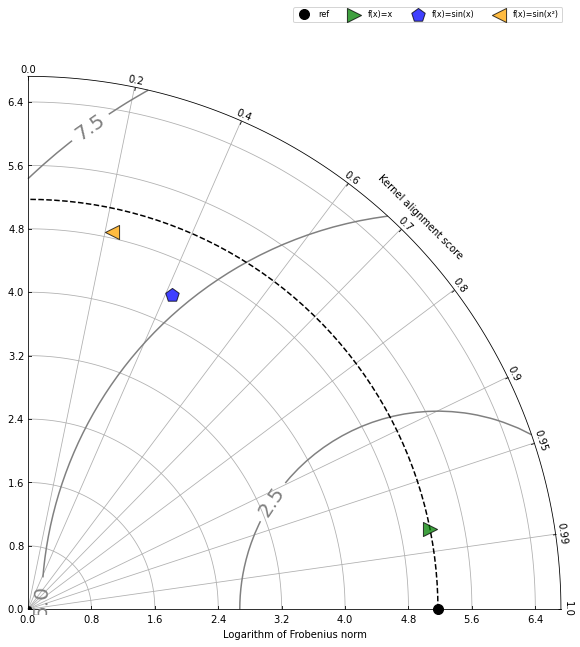

In [16]:
#@title Plotting


# ====================
# Reference Data
# ====================
ref_point = Fx


# correlation range
ref_range = (0, 30)
fig = plt.figure(figsize=(10, 10))

# add taylor diagram to plot
taylor_fig = TaylorDiagram(
    ref_point=ref_point,
    fig=fig,
    subplot=111,
    extend_angle=False,
    ref_range=ref_range,
    angle_label='Kernel alignment score',
    var_label="Logarithm of Frobenius norm"
)
# ========================
# plot reference point
# ========================
taylor_fig.add_reference_point(
    ref_point,
    color="black",
    marker=".",
    markersize=20,
    linestyle="",
    label="ref",
)

# ========================
# plot reference line
# ========================
taylor_fig.add_reference_line(ref_point, color="black", linestyle="--", label="_")

# ========================
# add grid
# ========================
taylor_fig.add_grid()

# ========================
# add contours
# ========================
taylor_fig.add_contours(ref_point, levels=3, colors="gray")

# modify contour labels
taylor_fig.polar_axes.clabel(taylor_fig.contours, inline=1, fontsize=20, fmt="%.1f")

# ========================
# add samples
# ========================

import matplotlib
marker_size, marker_type, opac = 150, '+', 0.9


cm = plt.cm.get_cmap("RdYlBu")
mark_list = [">", "p", "<", "s"]
col_list = ['green', 'blue', 'orange', 'black']
lab_list = ['f(x)=x', 'f(x)=sin(x)', 'f(x)=sin(x²)']

for i in range(len(func_list)):
    taylor_fig.add_scatter(
        points[i, 1],
        points[i, 0],
        c=col_list[i],
        s=200,
        marker=mark_list[i],
        label=lab_list[i],
        zorder=3,
        edgecolors='black',
        alpha=0.75
    )


taylor_fig.graph_axes.legend(ncol=4, bbox_to_anchor=(1.0, 1.125), prop={'size': 8})
#plt.rcParams.update({'font.size': 20})

plt.show()